# 🏥 Hospital Visit Analysis
Analyzing patient visit trends, doctor activity, department revenue, and more using hospital records.

## 📘 Project Overview
Healthcare data is critical to improving operational efficiency and patient outcomes.
In this project, we analyze a hospital visit dataset to uncover insights like:
- 💰 Revenue by department
- 👨‍⚕️ Most active doctors
- 👩‍⚕️ Frequent patients
- 📈 Monthly revenue trends
- 🧾 Average fee by diagnosis

The dataset was cleaned and normalized into multiple tables (patients, doctors, diagnosis, and visits),
stored in a SQLite database, and analyzed using SQL queries and Python visualizations.

## 📊 Dataset Summary
The dataset `hospital_visits_sample.csv` includes fields like:
- Patient ID, Patient Name
- Doctor, Department
- Revenue, Date of Admit & Discharge
- Risk Profile, Branch, Minutes to Service

In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
df = pd.read_csv("hospital_visits_sample.csv")
df.head()

,Row_ID,Date of Admit,Date of Discharge,Doctor,Hospital Branch,Department Type,Department,Patient ID,Patient Name,Patient Risk Profile,Revenue,Minutes to Service,Number of Patient Visits
0,6411,2/7/2019,2/12/2019,Leonard McCoy,East,General,General Surgery,2180,Bernard Strauss,Low,13420,23,1
1,6412,7/22/2019,NaN,Joseph Lister,Central,Labs,Microbiology,1389,Joel Buckley,Low,1280,20,1
2,6415,2/19/2018,NaN,Virginia Apgar,Central,Labs,Haematology,3330,Kara Foster,High,5300,11,1
3,6416,10/6/2019,10/7/2019,Anastasia Golovina,East,Specialty,Gastroenterology,2680,Esther Whitaker,Low,4015,23,1
4,8046,12/31/2019,1/3/2020,Anastasia Golovina,East,Specialty,Gastroenterology,2654,Bob Jiang,High,2035,9,1


## 🧹 Data Normalization
Breaking the flat file into structured tables for better querying and consistency.

In [8]:
patients = df[["Patient Name", "Patient ID"]].drop_duplicates().reset_index(drop=True)

In [9]:
doctors = df[["Doctor", "Department"]].drop_duplicates().reset_index(drop=True)
doctors["DoctorID"] = doctors.index + 1

In [10]:
diagnoses = df[["Revenue"]].drop_duplicates().reset_index(drop=True)
diagnoses["DiagnosisID"] = diagnoses.index + 1

In [11]:
df = df.merge(patients, on=["Patient Name", "Patient ID"])
df = df.merge(doctors, on=["Doctor", "Department"])
df = df.merge(diagnoses, on="Revenue")

In [12]:
conn = sqlite3.connect("hospital_visits_normalized.db")
patients.to_sql("Patient", conn, if_exists="replace", index=False)
doctors.to_sql("Doctor", conn, if_exists="replace", index=False)
diagnoses.to_sql("Diagnosis", conn, if_exists="replace", index=False)
df.to_sql("Visit", conn, if_exists="replace", index=False)
conn.commit()

## 📈 Data Analysis via SQL

In [23]:
queries = {
    "Revenue by Department": '''
        SELECT d.Department, SUM(v.Revenue) AS TotalRevenue
        FROM Visit v
        JOIN Doctor d ON v.DoctorID = d.DoctorID
        GROUP BY d.Department
        ORDER BY TotalRevenue DESC;
    ''',
    "Average Fee by Diagnosis": '''
        SELECT di.Revenue, AVG(v.Revenue) AS AverageFee
        FROM Visit v
        JOIN Diagnosis di ON v.DiagnosisID = di.DiagnosisID
        GROUP BY di.Revenue
        ORDER BY AverageFee DESC
        LIMIT 10;
    ''',
    "Most Frequent Patients": '''
        SELECT p."Patient Name", COUNT(v.Row_ID) AS VisitCount
        FROM Visit v
        JOIN Patient p ON v."Patient ID" = p."Patient ID"
        GROUP BY p."Patient Name"
        ORDER BY VisitCount DESC
        LIMIT 5;
    ''',
    "Most Active Doctors": '''
        SELECT d.Doctor, COUNT(v.Row_ID) AS VisitCount
        FROM Visit v
        JOIN Doctor d ON v.DoctorID = d.DoctorID
        GROUP BY d.Doctor
        ORDER BY VisitCount DESC
        LIMIT 5;
    ''',
    "Monthly Revenue Trend": '''
        SELECT SUBSTR("Date of Admit", 1, 7) AS Month, SUM(Revenue) AS Revenue
        FROM Visit
        GROUP BY Month
        ORDER BY Month;
    '''
}


In [14]:
results = {name: pd.read_sql_query(sql, conn) for name, sql in queries.items()}
conn.close()

## 📊 Visual Insights

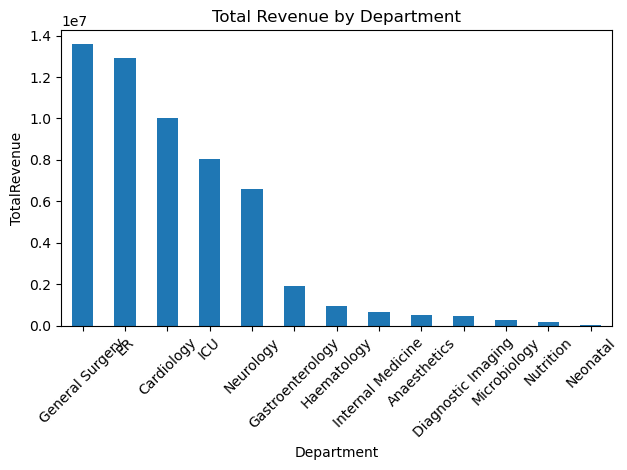

In [15]:
dept_df = results["Revenue by Department"]
dept_df.plot(kind="bar", x="Department", y="TotalRevenue", color="" if "" else None, legend=False, title="Total Revenue by Department")
plt.ylabel("TotalRevenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

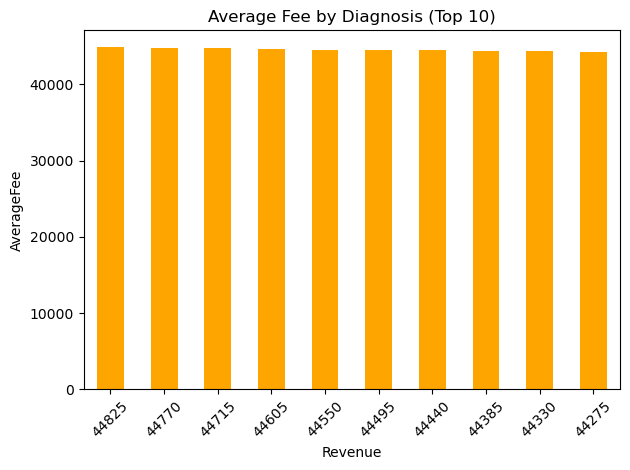

In [16]:
diag_df = results["Average Fee by Diagnosis"]
diag_df.plot(kind="bar", x="Revenue", y="AverageFee", color="orange" if "orange" else None, legend=False, title="Average Fee by Diagnosis (Top 10)")
plt.ylabel("AverageFee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

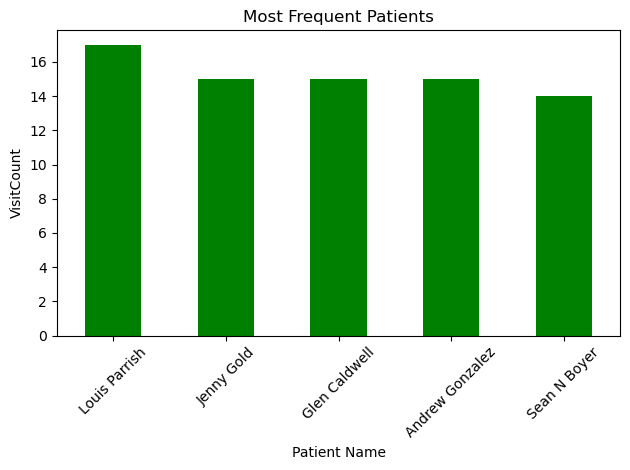

In [17]:
patient_df = results["Most Frequent Patients"]
patient_df.plot(kind="bar", x="Patient Name", y="VisitCount", color="green" if "green" else None, legend=False, title="Most Frequent Patients")
plt.ylabel("VisitCount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

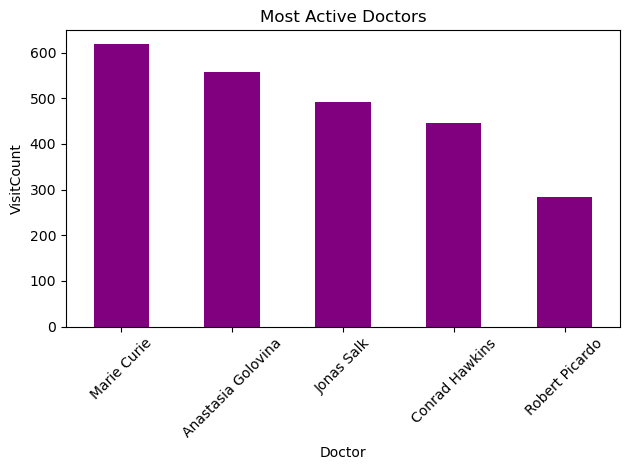

In [18]:
doctor_df = results["Most Active Doctors"]
doctor_df.plot(kind="bar", x="Doctor", y="VisitCount", color="purple" if "purple" else None, legend=False, title="Most Active Doctors")
plt.ylabel("VisitCount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

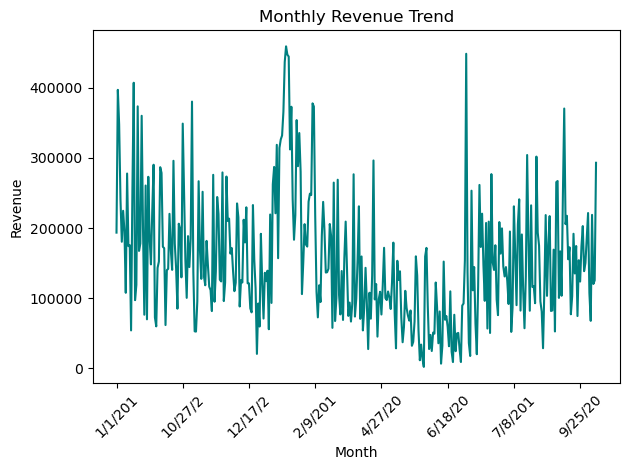

In [19]:
monthly_df = results["Monthly Revenue Trend"]
monthly_df.plot(kind="line", x="Month", y="Revenue", color="teal" if "teal" else None, legend=False, title="Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
print(df.columns)

Index(['Row_ID', 'Date of Admit', 'Date of Discharge', 'Doctor',
       'Hospital Branch', 'Department Type', 'Department', 'Patient ID',
       'Patient Name', 'Patient Risk Profile', 'Revenue', 'Minutes to Service',
       'Number of Patient Visits', 'DoctorID', 'DiagnosisID'],
      dtype='object')


In [21]:
print(diagnoses.columns)

Index(['Revenue', 'DiagnosisID'], dtype='object')
